#Using ResNet152v2

In [5]:
pip install ipykernel

Note: you may need to restart the kernel to use updated packages.


In [10]:
# pip list

/bin/bash: conda: command not found


In [57]:
# pip install seaborn
# !pip install plotly
# !pip install --upgrade nbformat
# !pip install --upgrade nbformat
!pip install visualkeras

     |████████████████████████████████| 992 kB 628 kB/s eta 0:00:01


In [14]:
pip install rarfile

Note: you may need to restart the kernel to use updated packages.


In [18]:
pip install unrar

Note: you may need to restart the kernel to use updated packages.


In [25]:
!which unrar

In [1]:
# Importing Libraries
import random
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib as mpl
from tensorflow import keras
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
tfk = tf.keras
layers = tf.keras.layers

In [2]:
import zipfile
import rarfile
import os

# Define the path to the zip file
zip_file_path = 'AnimalDataset.zip'

# Define the directory where you want to extract the contents
extract_dir = 'AnimalDataset'


In [3]:
# Create the extraction directory if it doesn't exist
if not os.path.exists(extract_dir):
    os.makedirs(extract_dir)


In [4]:
with zipfile.ZipFile(zip_file_path, mode='r') as zipref:
    zipref.extractall(extract_dir)

In [5]:
# !pip install google.colab

In [6]:
# from google.colab import drive

In [12]:
# drive.mount('/content/drive')

# Unziping the folder

In [30]:
# import zipfile

# zipfile_path = 'archive.zip'
# destination_folder = 'AnimalDataset'

# # 'r'-->   read the existing archive and extract its contents into the specified destination folder.
# # 'w' -->  it's meant for creating a new archive, not for extracting an existing one
# with zipfile.ZipFile(zipfile_path, 'r') as ref:
#     ref.extractall(output_path)

# print(f"Successfully extracted contents to {destination_folder}")

# Dataset Path

In [7]:
path = 'AnimalDataset/AnimalDataset/raw-img'

In [8]:
import os
class_names = sorted(os.listdir(path))
class_names
n_classes = len(class_names)
print(f"Class Names: \n{class_names}")
# print(f"Total Number of Classes : {n_classes}")

Class Names: 
['Butterfly', 'Cat', 'Cow', 'Dog', 'Hen']


In [9]:
class_dis = [len(os.listdir(path + f"/{name}")) for name in class_names]
print(f"Class Distribution : \n{class_dis}")

Class Distribution : 
[2113, 1668, 1866, 4863, 3098]


In [10]:
sum = sum(class_dis)
sum

13608

# Categorywise Dataset Visualization Using Pie Chart

In [12]:
import plotly.express as px
fig = px.pie(names=class_names, values=class_dis, width=600)
fig.update_layout({"title":{'text':"Class Distribution","x":0.5}})
fig.show()

# Data Augmentation

In [13]:
# Initialize Generator, to preprocess and augment image data for training and validation.
generator = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=20,
    validation_split=0.2
)


# Loads the training data from the specified directory and preprocesses it using the ImageDataGenerator object
train_ds = generator.flow_from_directory(
    path,
    target_size=(256,256),
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    subset='training')

# loads the validation data from the specified directory and preprocesses it using the ImageDataGenerator object.
valid_ds = generator.flow_from_directory(
    path,
    target_size=(256,256),
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    subset='validation')

Found 10889 images belonging to 5 classes.
Found 2719 images belonging to 5 classes.


In [14]:
def show_image(img, title=None):
    '''The function takes in a Image and plots it'''
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')

In [15]:
def get_random_data(data):
    '''The function gets random image and label from the input data'''
    images, labels = data
    id = np.random.randint(len(images))
    image, label = images[id], labels[id]
    return image, label

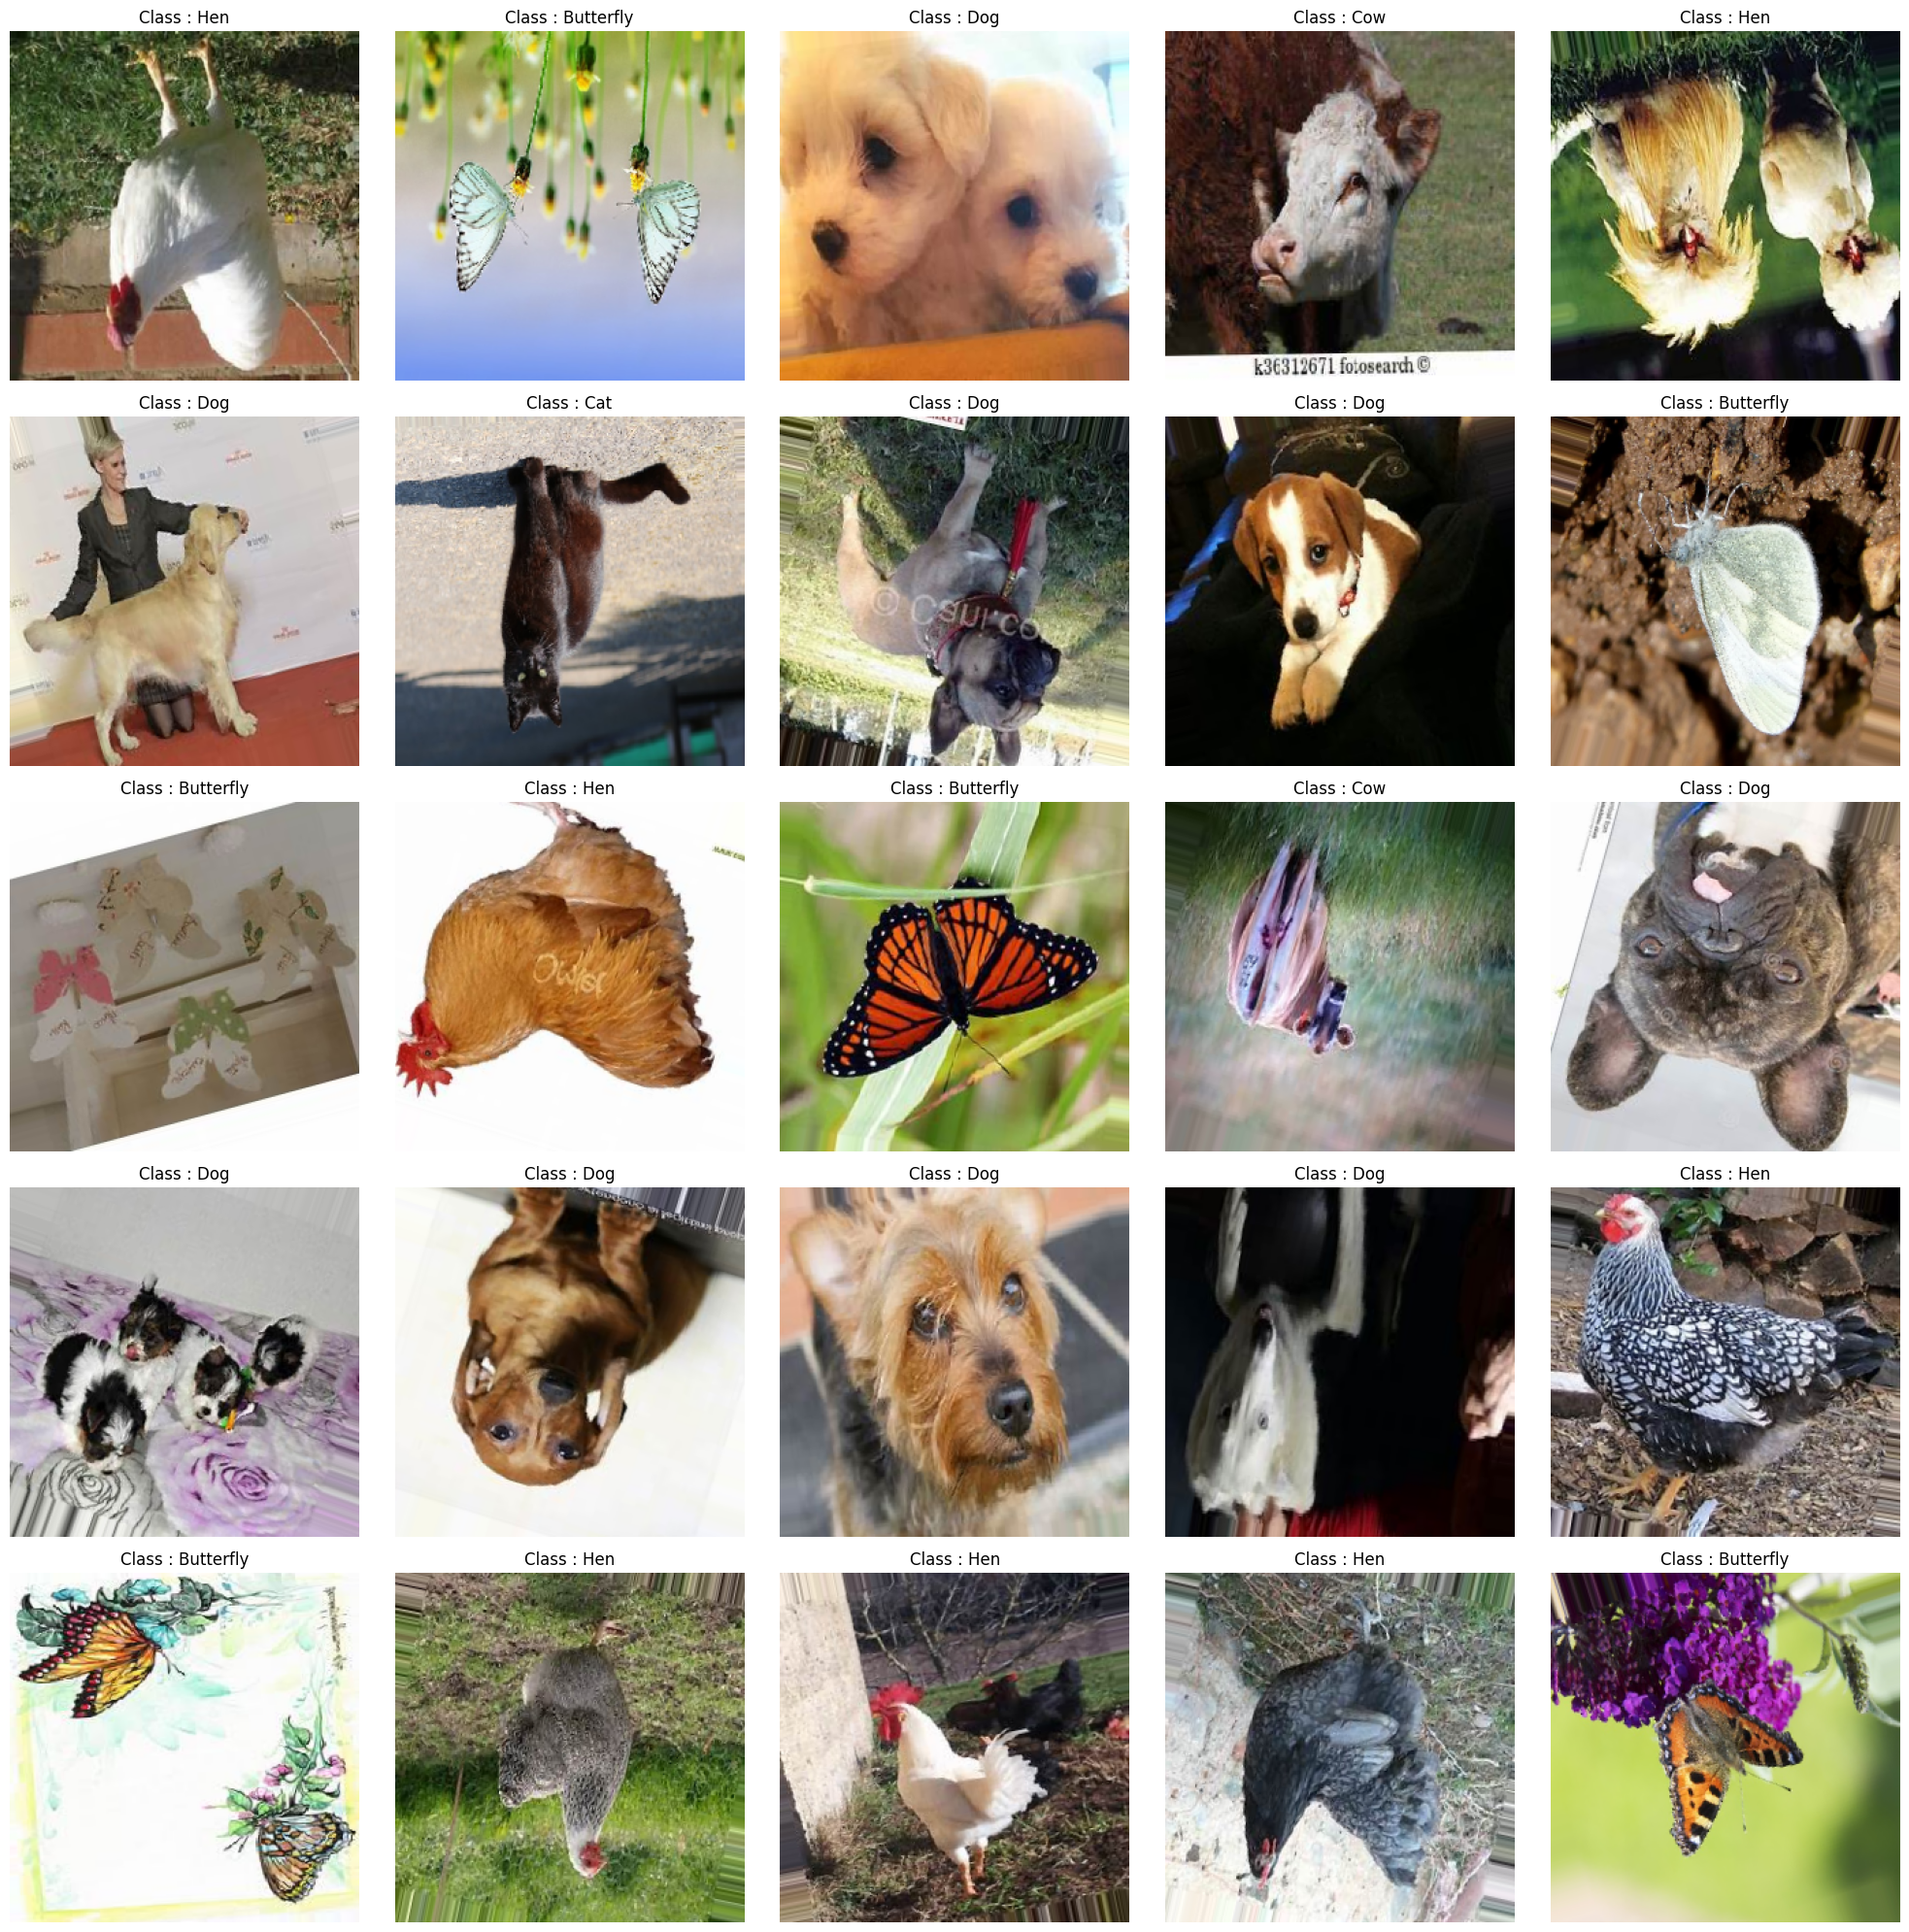

In [16]:
plt.figure(figsize=(20,20))
i=1
for images, labels in iter(train_ds):

    # Get Random Image and label
    image, label = get_random_data([images, labels])

    # Plot it
    plt.subplot(5,5,i)
    show_image(image, title=f"Class : {class_names[int(label)]}")

    # Make sure to end the Loop
    i+=1
    if i>=26: break


plt.tight_layout()
plt.show()

In [17]:
from tensorflow.keras.applications import ResNet152V2
from keras import Sequential
from keras.layers import Dense, GlobalAvgPool2D as GAP, Dropout

'''
include_top: This parameter specifies whether or not to include the fully-connected layer at the top of the network. 
If include_top=True, the model will include the fully-connected layer, which is used for classification. 
If include_top=False, the model will not include the fully-connected layer, which means that you will need to add your own fully-connected layer to the top of the model. 
The default value for include_top is True.
'''
base_model = ResNet152V2(include_top=False, input_shape=(256,256,3), weights='imagenet')
base_model.trainable = False # Freeze the Weights

# Model
name = "ResNet152V2"
resnet152V2 = Sequential([
    base_model,
    GAP(),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(n_classes, activation='softmax')
], name=name)


2024-04-05 19:02:57.122327: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-05 19:02:57.605161: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38420 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:07:00.0, compute capability: 8.0


234561536/234545216 [==============================] - 27s 0us/step


# Compile


In [23]:
resnet152V2.compile(
   loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
    )

In [24]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
cbs = [
   EarlyStopping(patience=3, restore_best_weights=True),
   ModelCheckpoint(name + ".h5", save_best_only=True)
 ]

# Model Summary

In [25]:
resnet152V2.summary()

Model: "ResNet152V2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 8, 8, 2048)        58331648  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 58,857,477
Trainable params: 525,829
Non-trainable params: 58,331,648
_____________________________________

In [26]:
import tqdm

In [44]:
history = resnet152V2.fit(
        train_ds, 
        validation_data=valid_ds,
        epochs=5,  # Train for 1 epoch at a time
        callbacks=cbs,
    )

Epoch 1/5
341/341 [==============================] - 129s 379ms/step - loss: 0.1574 - accuracy: 0.9456 - val_loss: 0.1518 - val_accuracy: 0.9485
Epoch 2/5
341/341 [==============================] - 129s 380ms/step - loss: 0.1314 - accuracy: 0.9534 - val_loss: 0.1360 - val_accuracy: 0.9581
Epoch 3/5
341/341 [==============================] - 129s 378ms/step - loss: 0.1249 - accuracy: 0.9545 - val_loss: 0.1729 - val_accuracy: 0.9434
Epoch 4/5
341/341 [==============================] - 129s 379ms/step - loss: 0.1203 - accuracy: 0.9582 - val_loss: 0.1567 - val_accuracy: 0.9463
Epoch 5/5
341/341 [==============================] - 129s 377ms/step - loss: 0.1075 - accuracy: 0.9603 - val_loss: 0.1476 - val_accuracy: 0.9540


In [42]:
history.history

{'loss': [0.18369492888450623],
 'accuracy': [0.9350720643997192],
 'val_loss': [0.1499343067407608],
 'val_accuracy': [0.9474071264266968]}

In [45]:
history.history

{'loss': [0.15737810730934143,
  0.13143174350261688,
  0.12490860372781754,
  0.12028860300779343,
  0.10746856778860092],
 'accuracy': [0.9456332325935364,
  0.9534392356872559,
  0.9545412659645081,
  0.9582147002220154,
  0.9603269100189209],
 'val_loss': [0.15182791650295258,
  0.13602593541145325,
  0.1729172319173813,
  0.15674127638339996,
  0.14760039746761322],
 'val_accuracy': [0.948510468006134,
  0.95807284116745,
  0.9433615207672119,
  0.9463037848472595,
  0.9540272355079651]}

# Visualize the validation and Training Error 

In [38]:
import matplotlib.pyplot as plt

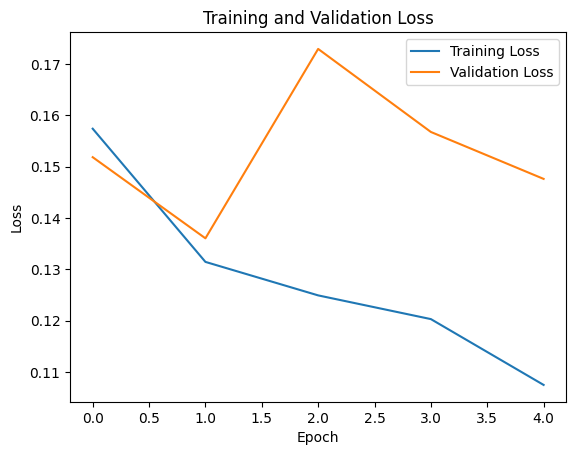

In [46]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

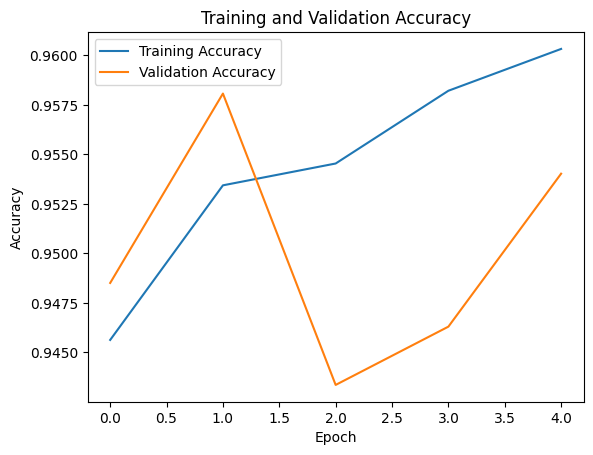

In [47]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Load the Model 

In [54]:
from tensorflow.keras.models import load_model

In [55]:
model = load_model('ResNet152V2.h5')

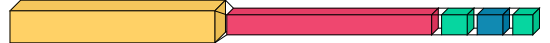

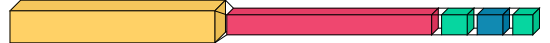

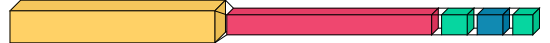

In [58]:
import visualkeras

visualkeras.layered_view(model).show()                        # display using your system viewer
visualkeras.layered_view(model, to_file='output.png')         # write to disk
visualkeras.layered_view(model, to_file='output.png').show()  # write and show

visualkeras.layered_view(model)

In [60]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet_v2 import preprocess_input, decode_predictions
from tensorflow.keras.models import load_model

In [61]:
# Load and preprocess an example image for prediction
image_path = 'test1.jpg'  
image_path = 'TestAnimalDataset/Butterfly/butterfly.jpeg'

# Adjust target_size based on your model's input size
img = image.load_img(image_path, target_size=(256, 256))  
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Make a prediction
predictions = model.predict(img_array)

#
class_labels = {0: 'Butterfly', 1: 'Cat', 2: 'Cow', 3: 'Dog', 4: 'Hen'}

# Get the top predicted class index
predicted_class_index = np.argmax(predictions)

# Map the class index to the corresponding label
predicted_class_label = class_labels[predicted_class_index]

# Print the predicted class label
print(f"Predicted Class: {predicted_class_label}")

1/1 [==============================] - 4s 4s/step
Predicted Class: Butterfly


# Accuracy 

In [29]:
test_path = 'TestAnimalDataset.zip'
test_save_path  = 'TestAnimalDataset'

In [33]:
with zipfile.ZipFile(test_path, 'r') as zipref:
    zipref.extractall(test_save_path)

In [49]:
test_path = 'TestAnimalDataset/TestAnimalDataset'

In [50]:
import os
class_names = sorted(os.listdir(test_path))
class_names = class_names[1:6]
n_classes = len(class_names)
print(f"Class Names: \n{class_names}")
print(f"Total Number of Classes : {n_classes}")

Class Names: 
['Butterfly', 'Cat', 'Cow', 'Dog', 'Hen']
Total Number of Classes : 5


In [51]:
class_dis = [len(os.listdir(test_path + f"/{name}")) for name in class_names]
print(f"Class Distribution : \n{class_dis}")

Class Distribution : 
[2, 3, 4, 3, 3]


In [52]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

test_gen = ImageDataGenerator(rescale=1./255)

# Load test data
test_ds = test_gen.flow_from_directory(
    test_path,
    target_size=(256, 256),
    class_mode='binary',
#     batch_size=3,
    shuffle=False
)

Found 14 images belonging to 6 classes.


In [61]:
test_ds.classes

array([1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5], dtype=int32)

In [62]:
test_ds.samples

14

In [69]:
true_labels = test_ds.labels
true_labels

array([1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5], dtype=int32)

In [72]:
# loss, accuracy = model.evaluate(test_ds)
# print('Test Loss:', loss)
# print('Test Accuracy:', accuracy)

# Make predictions on the test data
predictions = model.predict(test_ds)
prediction = np.argmax(predictions, axis=1)
print(prediction.shape)
print(prediction[7])

(14,)
2


In [73]:
from sklearn.metrics import confusion_matrix

In [75]:
conf_matrix = confusion_matrix(true_labels, prediction)
conf_matrix

array([[0, 0, 0, 0, 0, 0],
       [2, 0, 0, 0, 0, 0],
       [0, 3, 0, 0, 0, 0],
       [0, 0, 3, 0, 0, 0],
       [0, 0, 0, 3, 0, 0],
       [0, 0, 0, 0, 3, 0]])

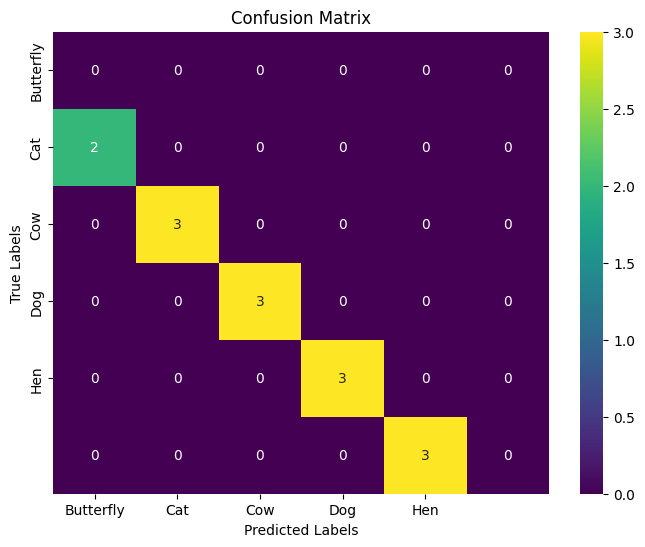

In [81]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='viridis', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [84]:
from sklearn.metrics import classification_report

# Generate classification report
class_report = classification_report(true_labels, prediction, target_names=class_names)

# Print classification report
print("Classification Report:")
print(class_report)

ValueError: Number of classes, 6, does not match size of target_names, 5. Try specifying the labels parameter

#### from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

true_labels = test_ds.classes

predicted_probabilities = model.predict(test_ds)
predicted_labels = np.argmax(predicted_probabilities, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Define the class labels
class_labels = list(test_ds.class_indices.keys())

# Plot the confusion matrix
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=class_labels,
       yticklabels=class_labels,
       title='Confusion Matrix',
       ylabel='True Label',
       xlabel='Predicted Label')

# Rotate the x-axis labels for better readability
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over the data and annotate the cells with the respective values
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, str(cm[i, j]),
                ha="center", va="center",
                color="white" if cm[i, j] > cm.max() / 2. else "black")

# Display the plot
plt.tight_layout()
plt.show()

In [86]:
!git init

Initialized empty Git repository in /workspace/ImageClassification/.git/
